# **Image segmentation using FCN-8 decoder**



## **Import thư viện**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import PIL
import os
import zipfile

## **1. Dataset**

### **1.1 Download and unpack the dataset**

In [ ]:
#Lệnh tải xuống một tệp tin zip có tên "m2nist.zip" từ URL
!wget --no-check-certificate https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip -O /tmp/m2nist.zip

--2023-06-20 03:37:26--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/m2nist.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17378168 (17M) [application/zip]
Saving to: ‘/tmp/m2nist.zip’

/tmp/m2nist.zip     100%[===================>]  16.57M  77.4MB/s    in 0.2s    

2023-06-20 03:37:26 (77.4 MB/s) - ‘/tmp/m2nist.zip’ saved [17378168/17378168]



In [ ]:
#Sử dụng thư viện **zipfile** trong Python để giải nén một tệp tin zip.
ZIP_DIR = '/tmp/m2nist.zip'
DATASET_DIR = '/dataset'

#để mở tệp tin zip với chế độ 'r' (đọc)
with zipfile.ZipFile(ZIP_DIR, 'r') as unpack:
  #Giải nén toàn bộ nội dung của tệp tin zip vào thư mục DATASET_DIR.
    unpack.extractall(DATASET_DIR)

### **1.2 Load dataset functions**

Dữ liệu được lưu trữ dưới dạng hai tệp tin Numpy cho hình ảnh và mặt nạ phân đoạn.

- **Images**: Là các hình ảnh có kích thước 64x84 chứa nhiều chữ số.

- **Segmentation**: Là các hình ảnh có kích thước 64x84x11 chứa các mặt nạ phân đoạn riêng biệt cho các chữ số từ 0-9 và nền.

Tổng cộng có **5000** mục records. Chúng ta chia chúng thành các tập dữ liệu train, test và validation.

### Tiền xử lý dữ liệu cho cả hình ảnh và mặt nạ phân đoạn.

In [ ]:
def preprocess_dataset(image, mask):
    # Chuyển đổi mask sang kiểu dữ liệu 'int32'
    mask = tf.cast(mask, dtype='int32')

    # Chuyển đổi image sang kiểu dữ liệu 'float32'
    image = tf.cast(image, dtype='float32')
    image /= 255  # Chuẩn hóa giá trị pixel trong khoảng [0, 1]
    image = tf.expand_dims(image, axis=-1)  # Thêm một chiều cuối cùng cho image

    return image, mask


###  Tạo ra các tập dữ liệu từ các tệp tin hình ảnh và phân đoạn.

In [ ]:
def create_datasets(images_dir, segmentation_dir):

    # Tải hình ảnh và phân đoạn từ các tệp tin
    images = np.load(images_dir)
    segmentation = np.load(segmentation_dir)

    # In kích thước của hình ảnh và phân đoạn
    print(f"Hình ảnh: {images.shape}\nPhân đoạn: {segmentation.shape}")

    # Chia tập hình ảnh và phân đoạn thành tập huấn luyện, kiểm tra và xác thực
    train_img, val_img, train_seg, val_seg = train_test_split(images, segmentation, test_size=0.2, shuffle=True)
    val_img, test_img, val_seg, test_seg = train_test_split(val_img, val_seg, test_size=0.2, shuffle=True)

    # In kích thước của các tập dữ liệu
    print(f'\nKích thước các tập dữ liệu:\nHuấn luyện: {train_img.shape[0]}\tKiểm tra: {test_img.shape[0]}\tXác thực: {val_img.shape[0]}')

    # Tạo Dataset huấn luyện từ tensor của hình ảnh và phân đoạn
    train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_seg))
    train_dataset = train_dataset.shuffle(512, reshuffle_each_iteration=True).batch(BATCH_SIZE)
    train_dataset = train_dataset.map(preprocess_dataset)

    # Tạo Dataset kiểm tra từ tensor của hình ảnh và phân đoạn
    test_dataset = tf.data.Dataset.from_tensor_slices((test_img, test_seg))
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
    test_dataset = test_dataset.map(preprocess_dataset)

    # Tạo Dataset xác thực từ tensor của hình ảnh và phân đoạn
    val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_seg))
    val_dataset = val_dataset.batch(BATCH_SIZE)
    val_dataset = val_dataset.map(preprocess_dataset)

    # Trả về các Dataset huấn luyện, kiểm tra và xác thực
    return train_dataset, test_dataset, val_dataset


### **1.3 Create the train, test and validation datasets**

In [ ]:
IMAGES_DIR = f'{DATASET_DIR}/combined.npy'
SEGMENTATION_DIR = f'{DATASET_DIR}/segmented.npy'
CLASSES_AMOUNT = 11
BATCH_SIZE = 32

print(f"Đang tải dữ liệu...\nSố lượng lớp: {CLASSES_AMOUNT}\n")

train_dataset, test_dataset, val_dataset = create_datasets(IMAGES_DIR, SEGMENTATION_DIR)


Đang tải dữ liệu...
Số lượng lớp: 11

Hình ảnh: (5000, 64, 84)
Phân đoạn: (5000, 64, 84, 11)

Kích thước các tập dữ liệu:
Huấn luyện: 4000	Kiểm tra: 200	Xác thực: 800


### **1.4 Preview sample images**

###  Chuyển đổi ma trận phân đoạn (mask) thành một ảnh màu tương ứng.

In [ ]:
def convert_mask_to_image(mask):
    # Tạo một mảng zeros với kích thước (mask.shape[0], mask.shape[1], 3) và kiểu dữ liệu float
    seg_img = np.zeros((mask.shape[0], mask.shape[1], 3)).astype('float')

    # Vòng lặp qua từng lớp trong số lượng lớp
    for c in range(CLASSES_AMOUNT):
        # Tạo một mặt nạ (segc) với các giá trị True tương ứng với lớp hiện tại
        segc = (mask == c)

        # Cộng dồn các giá trị màu cho từng kênh (R, G, B) của seg_img dựa trên segc và colors
        seg_img[:,:,0] += segc * (colors[c][0] * 255.0)
        seg_img[:,:,1] += segc * (colors[c][1] * 255.0)
        seg_img[:,:,2] += segc * (colors[c][2] * 255.0)

    # Chuyển đổi định dạng của seg_img sang kiểu dữ liệu uint8 và trả về
    return seg_img.astype('uint8')


### Hiển thị các cặp ảnh và phân đoạn tương ứng từ tập dataset.

In [ ]:
def preview_dataset(dataset, amount):
    # Định nghĩa số cột và số hàng để chia bố cục của các ảnh hiển thị trên đồ thị
    cols = 6
    rows = 2

    # Tạo đối tượng hình ảnh và các trục con với kích thước và bố cục đã chỉ định
    fig, axs = plt.subplots(nrows=rows * 2, ncols=cols, figsize=(10, 8))

    # Với mỗi cặp dữ liệu trong tập dataset (lấy tối đa "amount" cặp)
    for i, data in enumerate(dataset.take(amount)):
        image, mask = data

        # Gộp mask bằng cách lấy chỉ số lớp có giá trị cao nhất cho mỗi điểm ảnh
        merged_mask = np.argmax(mask, axis=3)

        # Chuyển đổi mask thành ảnh màu
        merged_mask = convert_mask_to_image(merged_mask[0])

        # Xác định chỉ số hàng cho ảnh và phân đoạn tương ứng
        img_index = i * 2
        seg_index = img_index + 1

        # Hiển thị ảnh gốc trên trục tương ứng
        axs[img_index // cols, img_index % cols].imshow(image[0], cmap='gray')
        axs[img_index // cols, img_index % cols].axis('off')

        # Hiển thị ảnh phân đoạn trên trục tương ứng
        axs[seg_index // cols, seg_index % cols].imshow(merged_mask)
        axs[seg_index // cols, seg_index % cols].axis('off')

    # Tăng tính gọn gàng của bố cục và hiển thị hình ảnh
    fig.tight_layout()
    fig.show()


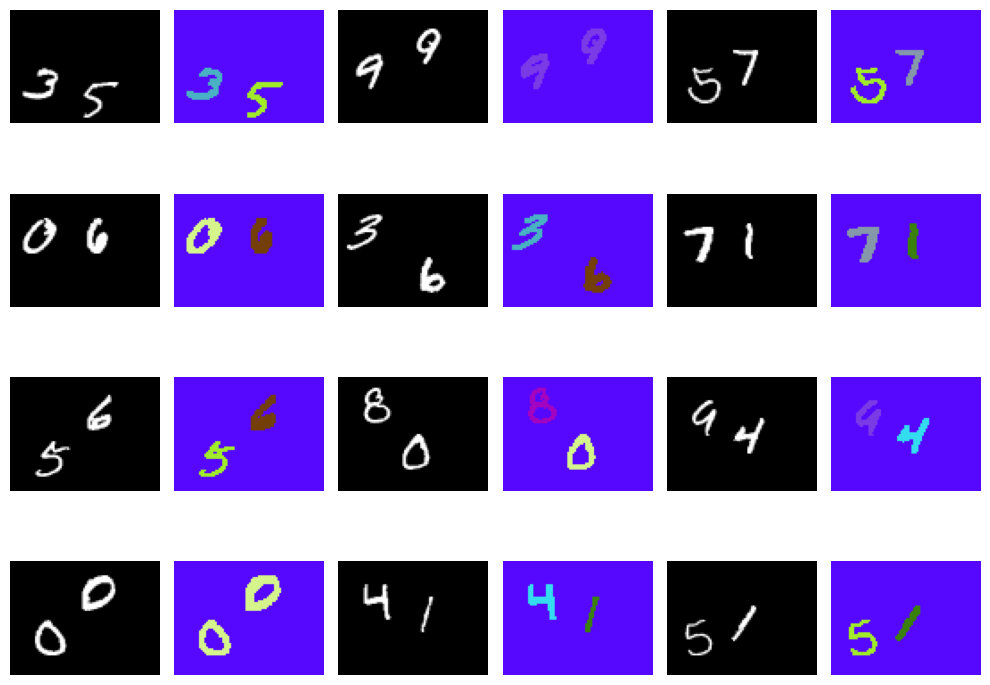

In [ ]:
#danh sách chứa các màu sắc ngẫu nhiên được tạo ra cho từng lớp trong số lượng lớp (CLASSES_AMOUNT)
colors = [tuple(np.random.randint(256, size=3) / 255.0) for i in range(CLASSES_AMOUNT)]
#xem trước 10 cặp dữ liệu từ tập train_dataset.
preview_dataset(train_dataset, amount=12)

## **2. FCN**

### **2.1 Downsampling path**

**Convolutional block**


### Xây dựng một khối tích chập trong mạng nơ-ron

In [ ]:
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, kernel_size, pooling_size, pool_strides, index):
    # Tạo lớp Conv2D với số lượng filters, kernel_size, padding và khởi tạo kernel đã chỉ định
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size,
                               padding='same',
                               kernel_initializer='he_normal',
                               data_format=IMAGE_ORDERING)(input)

    # Áp dụng hàm kích hoạt LeakyReLU
    x = tf.keras.layers.LeakyReLU()(x)

    # Tiếp tục tạo lớp Conv2D với số lượng filters, kernel_size, padding và khởi tạo kernel đã chỉ định
    x = tf.keras.layers.Conv2D(filters,
                               kernel_size,
                               padding='same',
                               kernel_initializer='he_normal',
                               data_format=IMAGE_ORDERING)(x)

    # Áp dụng hàm kích hoạt LeakyReLU
    x = tf.keras.layers.LeakyReLU()(x)

    # Tạo lớp MaxPooling2D với kích thước và bước dịch chuyển đã chỉ định
    x = tf.keras.layers.MaxPooling2D(pooling_size, strides=pool_strides)(x)

    # Tạo lớp BatchNormalization
    x = tf.keras.layers.BatchNormalization(name=f"END_OF_CONVBLOCK_{index}")(x)

    return x


###  Xây dựng mô hình Fully Convolutional Network (FCN-8).

In [ ]:
def FCN8(input_height=64, input_width=84):
    # Tạo một đầu vào img_input với kích thước (input_height, input_width, 1)
    img_input = tf.keras.layers.Input(shape=(input_height, input_width, 1))

    # Thực hiện Zero Padding trên đầu vào img_input để điều chỉnh kích thước của ảnh đến (input_height, 96)
    x = tf.keras.layers.ZeroPadding2D(((0, 0), (0, 96 - input_width)))(img_input)

    # Xây dựng khối tích chập đầu tiên
    x = conv_block(x, filters=32, kernel_size=3, pooling_size=2, pool_strides=2, index=1)
    # Xây dựng khối tích chập thứ hai
    x = conv_block(x, filters=64, kernel_size=3, pooling_size=2, pool_strides=2, index=2)
    # Xây dựng khối tích chập thứ ba
    x = conv_block(x, filters=128, kernel_size=3, pooling_size=2, pool_strides=2, index=3)
    # Lưu trữ đầu ra của khối tích chập thứ ba vào biến f3
    f3 = x

    # Xây dựng khối tích chập thứ tư
    x = conv_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2, index=4)
    # Lưu trữ đầu ra của khối tích chập thứ tư vào biến f4
    f4 = x

    # Xây dựng khối tích chập thứ năm
    x = conv_block(x, filters=256, kernel_size=3, pooling_size=2, pool_strides=2, index=5)
    # Lưu trữ đầu ra của khối tích chập thứ năm vào biến f5
    f5 = x
    # Trả về các đầu ra f3, f4, f5 cùng với đầu vào img_input
    return (f3, f4, f5), img_input


### **2.2 Upsampling path**

In [ ]:
def FCN8_decoder(convs, n_classes):
    f3, f4, f5 = convs
    n = 512

    # Lớp tích chập 6
    x = tf.keras.layers.Conv2D(filters=n,
                               kernel_size=(7,7),
                               activation='relu',
                               padding='same',
                               name="conv6",
                               data_format=IMAGE_ORDERING)(f5)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Lớp tích chập 7
    x = tf.keras.layers.Conv2D(filters=n,
                               kernel_size=(1, 1),
                               activation='relu',
                               padding='same',
                               name="conv7",
                               data_format=IMAGE_ORDERING)(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Lớp tích chập cuối cùng cho phân loại
    x = tf.keras.layers.Conv2D(filters=n_classes,
                               kernel_size=(1, 1),
                               activation='relu',
                               padding='same',
                               data_format=IMAGE_ORDERING)(x)

    # Tăng cường độ phân giải và kết nối bỏ qua
    x = tf.keras.layers.Conv2DTranspose(filters=n_classes,
                                        kernel_size=(4,4),
                                        strides=(2,2),
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(f5)
    x = tf.keras.layers.Cropping2D(cropping=(1,1))(x)

    # Kết nối bỏ qua và khối tích chập f4
    x2 = f4
    x2 = tf.keras.layers.Conv2D(filters=n_classes,
                                kernel_size=(1, 1),
                                activation='relu',
                                padding='same',
                                data_format=IMAGE_ORDERING)(x2)
    x = tf.keras.layers.Add()([x, x2])

    # Tăng cường độ phân giải và kết nối bỏ qua
    x = tf.keras.layers.Conv2DTranspose(filters=n_classes,
                                        kernel_size=(4,4),
                                        strides=(2,2),
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(x)
    x = tf.keras.layers.Cropping2D(cropping=(1, 1))(x)

    # Kết nối bỏ qua và khối tích chập f3
    x2 = f3
    x2 = tf.keras.layers.Conv2D(filters=n_classes,
                                kernel_size=(1, 1),
                                activation='relu',
                                padding='same',
                                data_format=IMAGE_ORDERING)(x2)
    x = tf.keras.layers.Add()([x, x2])

    # Tăng cường độ phân giải cuối cùng
    x = tf.keras.layers.Conv2DTranspose(filters=n_classes,
                                        kernel_size=(8,8),
                                        strides=(8,8),
                                        data_format=IMAGE_ORDERING,
                                        use_bias=False)(x)

    x = tf.keras.layers.Cropping2D(((0, 0), (0, 96-84)))(x)

    # Áp dụng hàm sigmoid cho đầu ra để có giá trị dự đoán nằm trong khoảng từ 0 đến
    y = (tf.keras.layers.Activation('sigmoid'))(x)

    return y


### **2.3 Complete model**

In [ ]:
# Tạo mô hình FCN-8
convs, img_input = FCN8()

# Tạo decoder sử dụng các feature maps từ encoder và số lượng lớp đầu ra
decoder = FCN8_decoder(convs, CLASSES_AMOUNT)

# Xây dựng mô hình bằng cách kết nối đầu vào và đầu ra
model = tf.keras.Model(inputs=img_input, outputs=decoder)

# Hiển thị tóm tắt thông tin về cấu trúc của mô hình
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 84, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 64, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 96, 32)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 96, 32)   0           ['conv2d[0][0]']                 
                                                                                              

## **3. Train model**



Sử dụng độ đo **OneHotIoU** (Intersection over Union), chúng ta có thể đánh giá hiệu suất của mô hình trong nhiệm vụ Segmentation so sánh với mặt nạ thực tế và dự đoán.

Chúng ta có thể xem giá trị IoU cho mỗi số, nhưng để làm điều này, chúng ta phải thiết lập một độ đo riêng biệt cho từng lớp được kiểm tra, điều này sẽ ảnh hưởng đáng kể đến hiệu suất. Điều này sẽ cải thiện tốc độ huấn luyện.

### $$IoU = \frac {area\ of\ overlap}{area\ of\ union}$$



### **3.1 Compile the model**

### Sử dụng phương thức **compile()** để cấu hình mô hình.

In [ ]:
model.compile(
    #hàm mất mát được sử dụng để đo lường sai khác giữa các dự đoán và nhãn thực tế.
    #ử dụng hàm mất mát "categorical_crossentropy" cho bài toán phân loại đa lớp.
    loss='categorical_crossentropy',
    #bộ tối ưu hóa được sử dụng để điều chỉnh các trọng số của mô hình dựa trên hàm mất mát và gradient của nó
    optimizer='adam',
    # danh sách các độ đo được sử dụng để đánh giá hiệu suất của mô hình trong quá trình đào tạo.
    #'accuracy': Đây là độ đo chính xác, đo lường tỷ lệ dự đoán chính xác của mô hình trên tập dữ liệu huấn luyện.
    #độ đo IoU (Intersection over Union), được tính cho từng lớp trong bài toán phân đoạn.
    metrics=['accuracy', tf.keras.metrics.OneHotIoU(num_classes=CLASSES_AMOUNT, target_class_ids=np.arange(CLASSES_AMOUNT))]
)

### **3.2 Train the model**


In [ ]:
# Số lần mô hình sẽ được huấn luyện trên toàn bộ tập dữ liệu huấn luyện.
EPOCHS = 20

# một callback của Keras được sử dụng để dừng quá trình huấn luyện sớm nếu không có sự cải thiện đáng kể trong mất mát trên tập validation.
#giúp tránh việc mô hình bị overfitting và tiết kiệm thời gian huấn luyện.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

#một callback khác của Keras được sử dụng để lưu trữ phiên bản tốt nhất của mô hình dựa trên mất mát trên tập validation.
# chỉ lưu lại phiên bản mô hình có hiệu suất tốt nhất trên tập validation.
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model/checkpoint/',
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      initial_value_threshold=0.03)

# lưu trữ thông tin về quá trình huấn luyện, bao gồm mất mát và các độ đo đánh giá được tính toán sau mỗi epoch.
#model.fit(): Phương thức này thực hiện quá trình huấn luyện mô hình.
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
125/125 [==============================] - 332s 3s/step - loss: 0.0481 - accuracy: 0.9801 - Digit 0: 0.7166 - Digit 1: 0.7659 - Digit 2: 0.6924 - Digit 3: 0.6599 - Digit 4: 0.6728 - Digit 5: 0.6449 - Digit 6: 0.7337 - Digit 7: 0.7090 - Digit 8: 0.7002 - Digit 9: 0.6834 - Digit 10: 0.9797 - val_loss: 0.0549 - val_accuracy: 0.9775 - val_Digit 0: 0.7093 - val_Digit 1: 0.7106 - val_Digit 2: 0.6300 - val_Digit 3: 0.6417 - val_Digit 4: 0.5297 - val_Digit 5: 0.5913 - val_Digit 6: 0.6853 - val_Digit 7: 0.6367 - val_Digit 8: 0.6616 - val_Digit 9: 0.6127 - val_Digit 10: 0.9780
Epoch 2/20
125/125 [==============================] - 316s 3s/step - loss: 0.0445 - accuracy: 0.9815 - Digit 0: 0.7395 - Digit 1: 0.7860 - Digit 2: 0.7221 - Digit 3: 0.6812 - Digit 4: 0.6939 - Digit 5: 0.6605 - Digit 6: 0.7499 - Digit 7: 0.7320 - Digit 8: 0.7195 - Digit 9: 0.7058 - Digit 10: 0.9809 - val_loss: 0.0544 - val_accuracy: 0.9788 - val_Digit 0: 0.6708 - val_Digit 1: 0.7810 - val_Digit 2: 0.6744 - val_D

125/125 [==============================] - 323s 3s/step - loss: 0.0228 - accuracy: 0.9908 - Digit 0: 0.8728 - Digit 1: 0.8996 - Digit 2: 0.8522 - Digit 3: 0.8372 - Digit 4: 0.8370 - Digit 5: 0.8237 - Digit 6: 0.8572 - Digit 7: 0.8708 - Digit 8: 0.8424 - Digit 9: 0.8408 - Digit 10: 0.9904 - val_loss: 0.0298 - val_accuracy: 0.9885 - val_Digit 0: 0.8377 - val_Digit 1: 0.8777 - val_Digit 2: 0.8145 - val_Digit 3: 0.8032 - val_Digit 4: 0.7775 - val_Digit 5: 0.7734 - val_Digit 6: 0.8089 - val_Digit 7: 0.8251 - val_Digit 8: 0.8018 - val_Digit 9: 0.7719 - val_Digit 10: 0.9889
Epoch 15/20
125/125 [==============================] - 309s 2s/step - loss: 0.0230 - accuracy: 0.9908 - Digit 0: 0.8722 - Digit 1: 0.8955 - Digit 2: 0.8534 - Digit 3: 0.8356 - Digit 4: 0.8357 - Digit 5: 0.8217 - Digit 6: 0.8557 - Digit 7: 0.8709 - Digit 8: 0.8413 - Digit 9: 0.8396 - Digit 10: 0.9904 - val_loss: 0.0308 - val_accuracy: 0.9883 - val_Digit 0: 0.8312 - val_Digit 1: 0.8705 - val_Digit 2: 0.8105 - val_Digit 3: 0.

125/125 [==============================] - 317s 3s/step - loss: 0.0207 - accuracy: 0.9917 - Digit 0: 0.8820 - Digit 1: 0.9094 - Digit 2: 0.8667 - Digit 3: 0.8524 - Digit 4: 0.8506 - Digit 5: 0.8367 - Digit 6: 0.8677 - Digit 7: 0.8834 - Digit 8: 0.8550 - Digit 9: 0.8572 - Digit 10: 0.9913 - val_loss: 0.0281 - val_accuracy: 0.9894 - val_Digit 0: 0.8435 - val_Digit 1: 0.8824 - val_Digit 2: 0.8323 - val_Digit 3: 0.8155 - val_Digit 4: 0.7918 - val_Digit 5: 0.7949 - val_Digit 6: 0.8291 - val_Digit 7: 0.8374 - val_Digit 8: 0.8122 - val_Digit 9: 0.7900 - val_Digit 10: 0.9899
Epoch 20/20
125/125 [==============================] - 307s 2s/step - loss: 0.0198 - accuracy: 0.9921 - Digit 0: 0.8885 - Digit 1: 0.9135 - Digit 2: 0.8734 - Digit 3: 0.8594 - Digit 4: 0.8565 - Digit 5: 0.8441 - Digit 6: 0.8729 - Digit 7: 0.8897 - Digit 8: 0.8595 - Digit 9: 0.8642 - Digit 10: 0.9917 - val_loss: 0.0282 - val_accuracy: 0.9893 - val_Digit 0: 0.8407 - val_Digit 1: 0.8820 - val_Digit 2: 0.8164 - val_Digit 3: 0.

### **3.3 Display accuracy and loss plot**


### Tạo và hiển thị biểu đồ đánh giá hiệu suất của mô hình sau quá trình huấn luyện

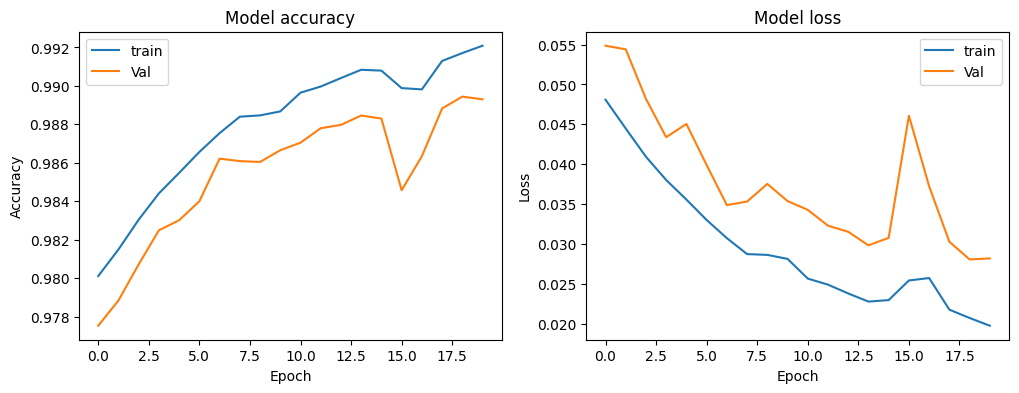

In [ ]:
#Tạo một hình ảnh có 1 hàng và 2 cột để chứa hai biểu đồ.
fig, axs = plt.subplots(1, 2, figsize=(12,4))

#Đặt tiêu đề cho biểu đồ thứ nhất, biểu thị độ chính xác của mô hình.
axs[0].set_title("Model accuracy")
#Vẽ đường cong độ chính xác trên tập huấn luyện và tập validation.
axs[0].plot(history.history["accuracy"])
axs[0].plot(history.history["val_accuracy"])
#Hiển thị chú thích cho các đường cong, cho biết đường nào tương ứng với tập huấn luyện và tập validation.
axs[0].legend(["train", "Val"], loc="upper left")
#Đặt nhãn cho trục y là "Accuracy".
axs[0].set_ylabel("Accuracy")
#Đặt nhãn cho trục x là "Epoch".
axs[0].set_xlabel("Epoch")

#Đặt tiêu đề cho biểu đồ thứ hai, biểu thị hàm mất mát của mô hình.
axs[1].set_title("Model loss")
#Vẽ đường cong hàm mất mát trên tập huấn luyện và tập validation.
axs[1].plot(history.history["loss"])
axs[1].plot(history.history["val_loss"])
#Hiển thị chú thích cho các đường cong, cho biết đường nào tương ứng với tập huấn luyện và tập validation.
axs[1].legend(["train", "Val"], loc="upper right")
#Đặt nhãn cho trục y là "Loss".
axs[1].set_ylabel("Loss")
#Đặt nhãn cho trục x là "Epoch".
axs[1].set_xlabel("Epoch")

#Hiển thị biểu đồ trên màn hình.
fig.show()

## **4. Evaluation**

### **4.1 Intersection over Union (IoU)**


Tính toán **IoU** cho từng chữ số, để làm điều này sử dụng một kỹ thuật để thêm một đánh giá cho mỗi chữ số và đánh giá mô hình trên tập dữ liệu kiểm tra.

**IoU** cung cấp thông tin bổ sung về hiệu suất của mô hình. Có thể thấy rõ ràng rằng độ chính xác 98% không có nghĩa là việc phân đoạn trùng nhau đạt 98%.

In [ ]:
#Tạo ra một danh sách các metrics IoU (Intersection over Union) cho từng chữ số.
#Mỗi metric được tạo với một ID chữ số tương ứng và tên tương ứng.
iou_metrics = [tf.keras.metrics.OneHotIoU(num_classes=CLASSES_AMOUNT, target_class_ids=[i], name=f"Digit {i}") for i in range(CLASSES_AMOUNT)]
#mô hình được biên dịch (compile) với hàm mất mát là 'categorical_crossentropy',
#bộ tối ưu hóa là 'adam' và các metrics bao gồm 'accuracy' và danh sách các metrics IoU đã tạo.
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'] + iou_metrics
)

#đánh giá mô hình trên tập dữ liệu kiểm tra và lưu trữ kết quả đánh giá vào biến metrics_eval.
metrics_eval = model.evaluate(test_dataset)

#in ra kết quả đánh giá bao gồm giá trị mất mát (Loss) và độ chính xác (Accuracy).
print(f"\nLoss: {metrics_eval[0]:.4f}\nAccuracy: {metrics_eval[1]:.4f}\n")

#n ra giá trị IoU cho từng chữ số từ 0 đến 9.
for i in range(2,12):
    print(f'Digit {i-2}: {metrics_eval[i]:.4f}')

#in ra giá trị IoU cho giá trị nền (Background).
print(f"\nBackground: {metrics_eval[12]:.4f}")

6/6 [==============================] - 12s 870ms/step - loss: 0.0296 - accuracy: 0.9894 - Digit 0: 0.8438 - Digit 1: 0.9013 - Digit 2: 0.7866 - Digit 3: 0.8274 - Digit 4: 0.8055 - Digit 5: 0.7857 - Digit 6: 0.8078 - Digit 7: 0.8545 - Digit 8: 0.8165 - Digit 9: 0.6814 - Digit 10: 0.9903

Loss: 0.0296
Accuracy: 0.9894

Digit 0: 0.8438
Digit 1: 0.9013
Digit 2: 0.7866
Digit 3: 0.8274
Digit 4: 0.8055
Digit 5: 0.7857
Digit 6: 0.8078
Digit 7: 0.8545
Digit 8: 0.8165
Digit 9: 0.6814

Background: 0.9903


### **4.2 F1 score**



F1 score là 1 cách đánh giá khác cho biết mô hình hoạt động tốt như thế nào. Nó bao gồm Precision và Recall
* Precision: đo độ chính xác của các dự đoán positive.
* Recall: đo lường khả năng xác định những identify true positives.

$$Precision = \frac{TP}{TP+FP}~~~~~~ Recall = \frac{TP}{TP+FN}$$

The final equation:

### $$F1 = 2\frac {Precision * Recall}{Precision + Recall}$$


### Lấy kết quả dự đoán từ mô hình và thực hiện một số xử lý trên kết quả đó.



In [ ]:
#sử dụng mô hình đã được huấn luyện để dự đoán kết quả trên tập dữ liệu kiểm tra
results = model.predict(test_dataset)
print(results.shape)

#chọn lớp có xác suất cao nhất từ kết quả dự đoán
results = np.argmax(results, axis=3)
print(results.shape)

6/6 [==============================] - 6s 1s/step
(192, 64, 84, 11)
(192, 64, 84)


#### **F1 score helper functions**

### Tính toán F1 score giữa y_true (giá trị đúng) và y_pred (giá trị dự đoán).

In [ ]:
def get_f1_score(y_true, y_pred, average='binary'):
    # Tạo một mặt nạ để xác định các vị trí có giá trị -1 trong y_true hoặc y_pred
    unknown_mask = np.logical_or(y_true == -1, y_pred == -1)

    # Tính toán F1 score bằng cách loại bỏ các vị trí có giá trị -1
    f1 = f1_score(y_true[~unknown_mask], y_pred[~unknown_mask], average=average, zero_division=0)

    return f1


### Tính toán F1 score cho mỗi lớp trong bài toán phân loại đa lớp.

In [ ]:
def get_f1_score_per_class(y_true, y_pred, n_classes):

    f1_list = []

    for i in range(n_classes):
        # Tạo một mảng chỉ chứa nhãn của một lớp cụ thể
        y_true_single_class = (y_true == i)
        y_pred_single_class = (y_pred == i)

        # Tính toán F1 score cho lớp đó
        f1 = get_f1_score(y_true_single_class, y_pred_single_class)
        f1_list.append(f1)

    return f1_list


#### **Calculate the F1 score per digit**


In [ ]:
# Tạo một mảng y_true bằng cách ghép các mảng nhãn từ tập dữ liệu kiểm tra test_dataset.
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
#Chuyển đổi y_true từ định dạng one-hot về dạng chỉ chứa các giá trị nhãn thông qua việc sử dụng hàm np.argmax với trục 3.
y_true = np.argmax(y_true, axis=3)

# Tính toán F1 score cho từng lớp
f1_per_class = get_f1_score_per_class(y_true, results, CLASSES_AMOUNT-1)

# Tính toán F1 score tổng quát
f1_total = get_f1_score(y_true, results, average='macro')

print("f1 score per digit:")

# In ra F1 score cho từng lớp
for i in range(CLASSES_AMOUNT-1):
    print(f'Digit {i}\t f1 score: {f1_per_class[i]:.4f}')

print(f'\nTotal f1 score: {f1_total:.4f}')


f1 score per digit:
Digit 0	 f1 score: 0.9153
Digit 1	 f1 score: 0.9481
Digit 2	 f1 score: 0.8806
Digit 3	 f1 score: 0.9056
Digit 4	 f1 score: 0.8924
Digit 5	 f1 score: 0.8800
Digit 6	 f1 score: 0.8937
Digit 7	 f1 score: 0.9215
Digit 8	 f1 score: 0.8989
Digit 9	 f1 score: 0.8105

Total f1 score: 0.9038


### **4.3 Visualize predictions**

### Hiển thị ba hình ảnh cùng một lúc để so sánh

In [ ]:
def visualize_prediction(image, y_true, y_pred):
    # Tạo ra một hình vẽ và ba trục con để hiển thị hình ảnh gốc, nhãn chính xác và nhãn dự đoán
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))

    # Hiển thị hình ảnh gốc
    axs[0].imshow(image)
    axs[0].axis('off')

    # Hiển thị nhãn chính xác
    axs[1].imshow(y_true)
    axs[1].axis('off')

    # Hiển thị nhãn dự đoán
    axs[2].imshow(y_pred)
    axs[2].axis('off')

    # Hiển thị hình vẽ với ba hình ảnh đã được cắt và hiển thị trên các trục tương ứng
    fig.show()


###  Thực hiện dự đoán và đánh giá mô hình trên tập dữ liệu kiểm tra

1/1 [==============================] - 0s 72ms/step
Digit 7 F1 score: 0.8936
Digit 9 F1 score: 0.7570


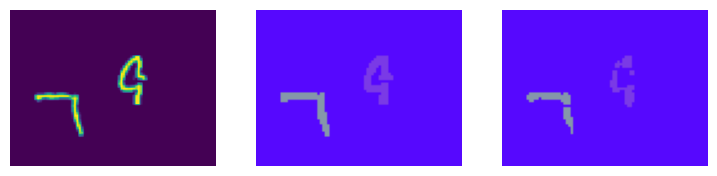

In [ ]:
unbatched_test = test_dataset.unbatch()

samples_amount = 10

for img, mask in unbatched_test.take(1):
    # Khởi tạo một biến dùng để chứa ảnh dự đoán
    pred_img = np.expand_dims(img, axis=0)
    # Dự đoán bằng cách sử dụng mô hình trên ảnh dự đoán
    pred = model.predict(pred_img)

    # Chuyển đổi mask và pred về dạng 2D bằng cách lấy chỉ số của giá trị lớn nhất
    mask = np.argmax(mask, axis=2)
    pred = np.argmax(pred, axis=3)

    # Tính toán F1 score cho từng class
    f1_per_class = get_f1_score_per_class(mask, np.squeeze(pred), CLASSES_AMOUNT-1)

    # Loại bỏ chiều thứ ba của mask và pred
    mask = np.squeeze(mask)
    pred = np.squeeze(pred)

    # In ra F1 score cho từng class khác 0
    for i in range(CLASSES_AMOUNT-1):
        if f1_per_class[i] != 0:
           print(f'Digit {i} F1 score: {f1_per_class[i]:.4f}')

    # Hiển thị hình ảnh gốc, mask và pred
    visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
    plt.pause(0.1)


1/1 [==============================] - 1s 658ms/step
Digit 7 F1 score: 0.8936
Digit 9 F1 score: 0.7570


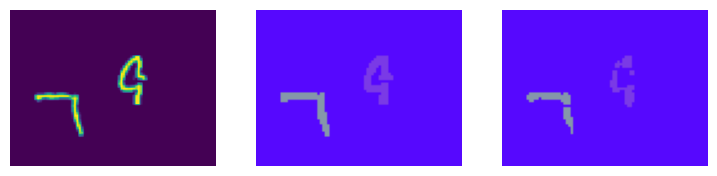

1/1 [==============================] - 0s 197ms/step
Digit 1 F1 score: 0.9514
Digit 5 F1 score: 0.9248


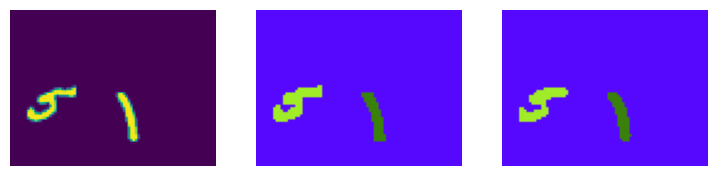

1/1 [==============================] - 0s 124ms/step
Digit 8 F1 score: 0.9012


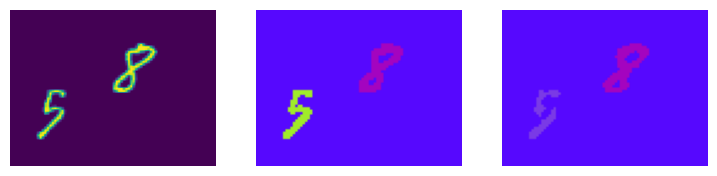

1/1 [==============================] - 0s 94ms/step
Digit 3 F1 score: 0.9145
Digit 6 F1 score: 0.9218


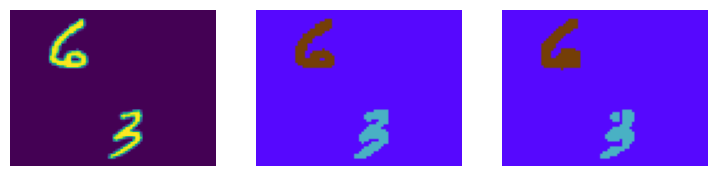

1/1 [==============================] - 0s 85ms/step
Digit 0 F1 score: 0.9412
Digit 7 F1 score: 0.9665


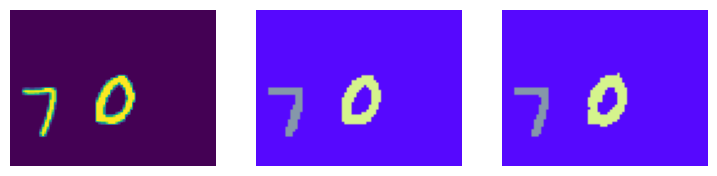

In [ ]:
unbatched_test = test_dataset.unbatch()

samples_amount = 10

for img, mask in unbatched_test.take(5):
    # Khởi tạo một biến dùng để chứa ảnh dự đoán
    pred_img = np.expand_dims(img, axis=0)
    # Dự đoán bằng cách sử dụng mô hình trên ảnh dự đoán
    pred = model.predict(pred_img)

    # Chuyển đổi mask và pred về dạng 2D bằng cách lấy chỉ số của giá trị lớn nhất
    mask = np.argmax(mask, axis=2)
    pred = np.argmax(pred, axis=3)

    # Tính toán F1 score cho từng class
    f1_per_class = get_f1_score_per_class(mask, np.squeeze(pred), CLASSES_AMOUNT-1)

    # Loại bỏ chiều thứ ba của mask và pred
    mask = np.squeeze(mask)
    pred = np.squeeze(pred)

    # In ra F1 score cho từng class khác 0
    for i in range(CLASSES_AMOUNT-1):
        if f1_per_class[i] != 0:
           print(f'Digit {i} F1 score: {f1_per_class[i]:.4f}')

    # Hiển thị hình ảnh gốc, mask và pred
    visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
    plt.pause(0.1)


1/1 [==============================] - 0s 48ms/step
Digit 7 F1 score: 0.8936
Digit 9 F1 score: 0.7570


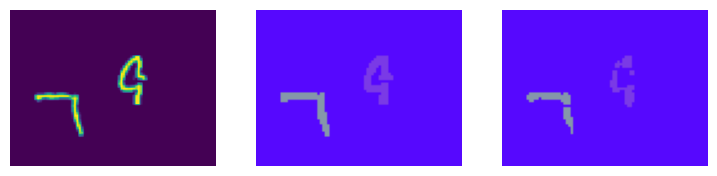

1/1 [==============================] - 0s 45ms/step
Digit 1 F1 score: 0.9514
Digit 5 F1 score: 0.9248


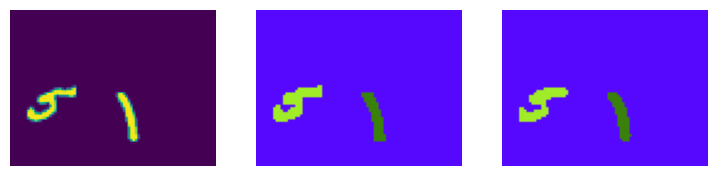

1/1 [==============================] - 0s 48ms/step
Digit 8 F1 score: 0.9012


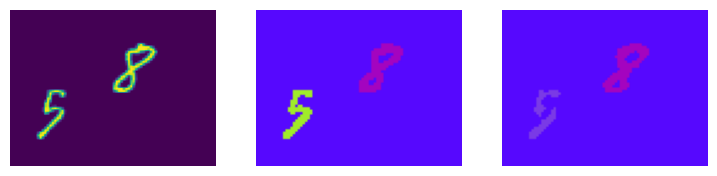

1/1 [==============================] - 0s 53ms/step
Digit 3 F1 score: 0.9145
Digit 6 F1 score: 0.9218


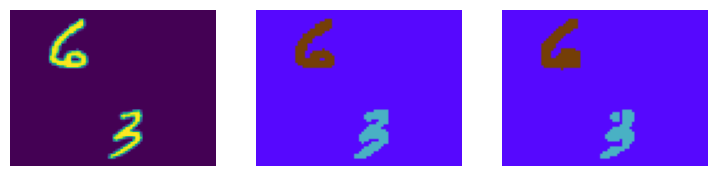

1/1 [==============================] - 0s 46ms/step
Digit 0 F1 score: 0.9412
Digit 7 F1 score: 0.9665


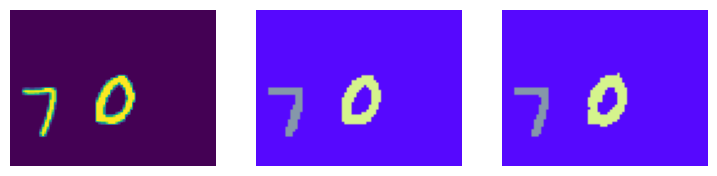

1/1 [==============================] - 0s 42ms/step
Digit 8 F1 score: 0.9196


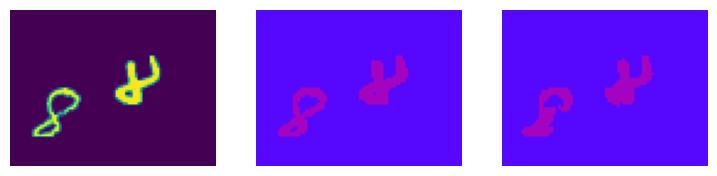

1/1 [==============================] - 0s 51ms/step
Digit 3 F1 score: 0.9590
Digit 5 F1 score: 0.8815


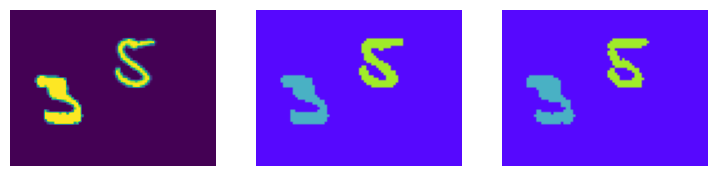

1/1 [==============================] - 0s 51ms/step
Digit 2 F1 score: 0.9470
Digit 5 F1 score: 0.9084


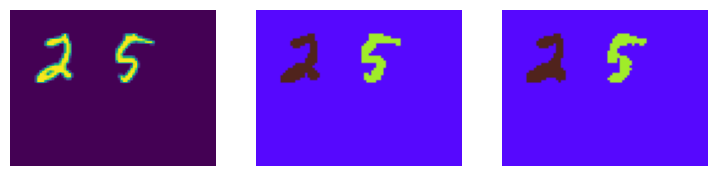

1/1 [==============================] - 0s 45ms/step
Digit 1 F1 score: 0.9613
Digit 8 F1 score: 0.9579


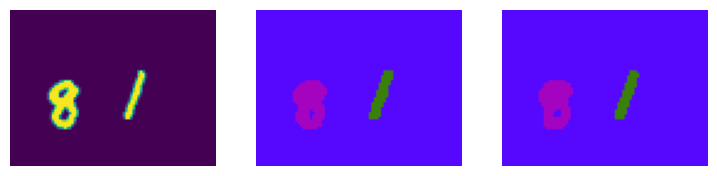

1/1 [==============================] - 0s 48ms/step
Digit 2 F1 score: 0.9271
Digit 4 F1 score: 0.8421


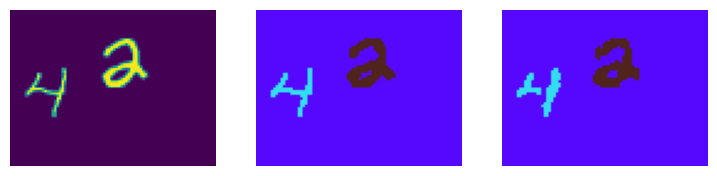

In [ ]:
unbatched_test = test_dataset.unbatch()

samples_amount = 10

for img, mask in unbatched_test.take(10):
    # Khởi tạo một biến dùng để chứa ảnh dự đoán
    pred_img = np.expand_dims(img, axis=0)
    # Dự đoán bằng cách sử dụng mô hình trên ảnh dự đoán
    pred = model.predict(pred_img)

    # Chuyển đổi mask và pred về dạng 2D bằng cách lấy chỉ số của giá trị lớn nhất
    mask = np.argmax(mask, axis=2)
    pred = np.argmax(pred, axis=3)

    # Tính toán F1 score cho từng class
    f1_per_class = get_f1_score_per_class(mask, np.squeeze(pred), CLASSES_AMOUNT-1)

    # Loại bỏ chiều thứ ba của mask và pred
    mask = np.squeeze(mask)
    pred = np.squeeze(pred)

    # In ra F1 score cho từng class khác 0
    for i in range(CLASSES_AMOUNT-1):
        if f1_per_class[i] != 0:
           print(f'Digit {i} F1 score: {f1_per_class[i]:.4f}')

    # Hiển thị hình ảnh gốc, mask và pred
    visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
    plt.pause(0.1)


1/1 [==============================] - 0s 74ms/step
Digit 7 F1 score: 0.8936
Digit 9 F1 score: 0.7570


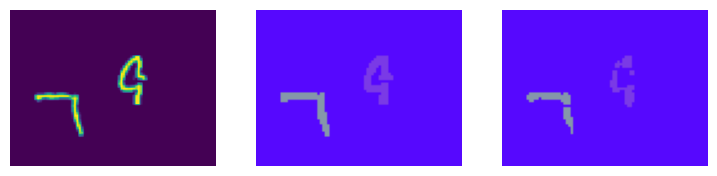

1/1 [==============================] - 0s 42ms/step
Digit 1 F1 score: 0.9514
Digit 5 F1 score: 0.9248


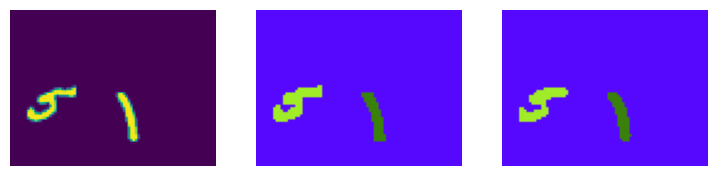

1/1 [==============================] - 0s 48ms/step
Digit 8 F1 score: 0.9012


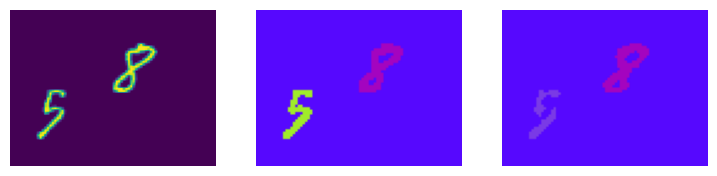

1/1 [==============================] - 0s 41ms/step
Digit 3 F1 score: 0.9145
Digit 6 F1 score: 0.9218


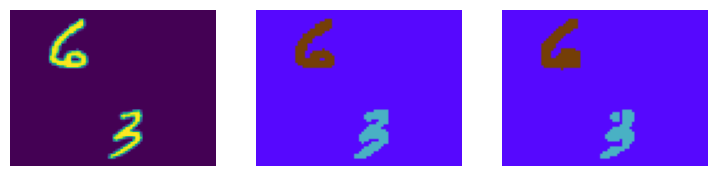

1/1 [==============================] - 0s 46ms/step
Digit 0 F1 score: 0.9412
Digit 7 F1 score: 0.9665


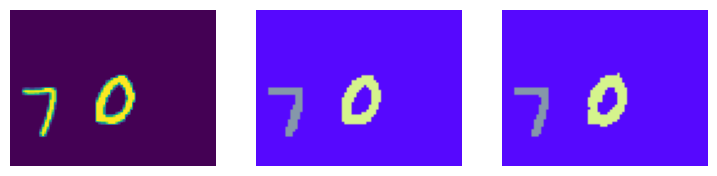

1/1 [==============================] - 0s 41ms/step
Digit 8 F1 score: 0.9196


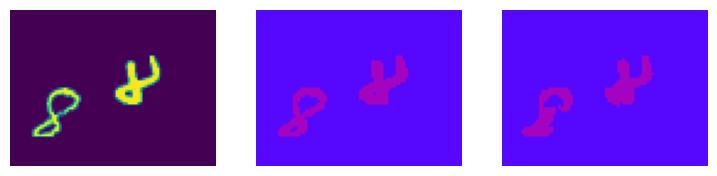

1/1 [==============================] - 0s 43ms/step
Digit 3 F1 score: 0.9590
Digit 5 F1 score: 0.8815


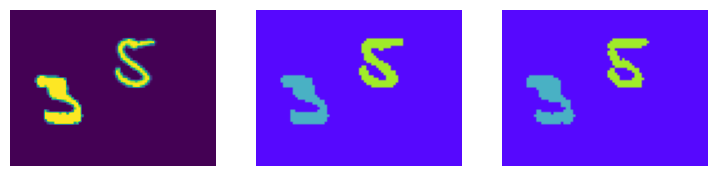

1/1 [==============================] - 0s 40ms/step
Digit 2 F1 score: 0.9470
Digit 5 F1 score: 0.9084


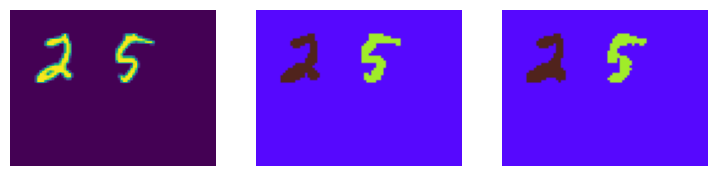

1/1 [==============================] - 0s 41ms/step
Digit 1 F1 score: 0.9613
Digit 8 F1 score: 0.9579


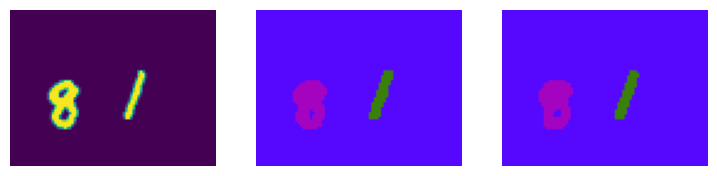

1/1 [==============================] - 0s 41ms/step
Digit 2 F1 score: 0.9271
Digit 4 F1 score: 0.8421


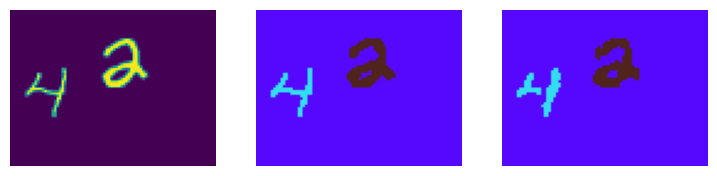

1/1 [==============================] - 0s 41ms/step
Digit 2 F1 score: 0.9454
Digit 3 F1 score: 0.9355


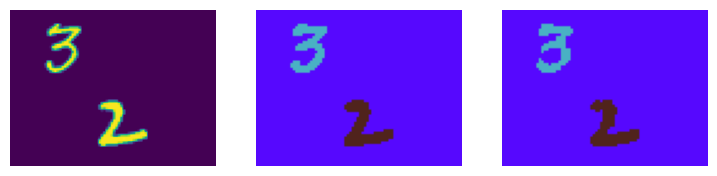

1/1 [==============================] - 0s 51ms/step
Digit 3 F1 score: 0.8649


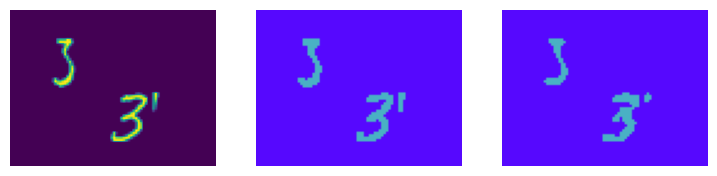

1/1 [==============================] - 0s 42ms/step
Digit 8 F1 score: 0.9082


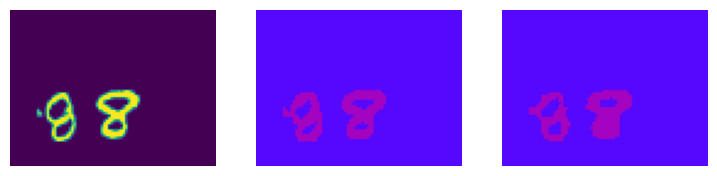

1/1 [==============================] - 0s 45ms/step
Digit 2 F1 score: 0.9223
Digit 7 F1 score: 0.9504


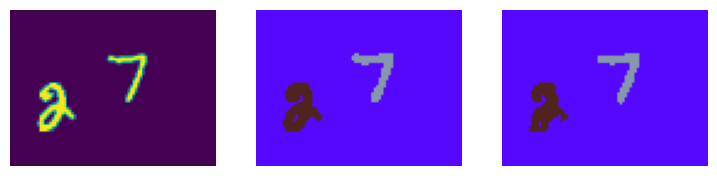

1/1 [==============================] - 0s 41ms/step
Digit 0 F1 score: 0.9074
Digit 1 F1 score: 0.9054


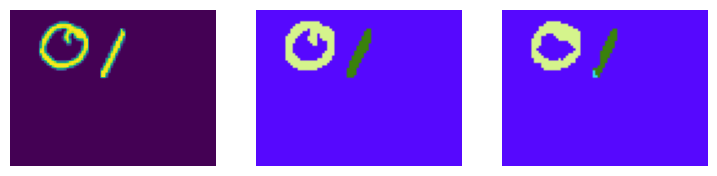

1/1 [==============================] - 0s 41ms/step
Digit 0 F1 score: 0.9246
Digit 6 F1 score: 0.8963


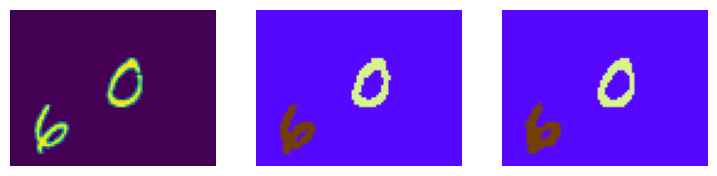

1/1 [==============================] - 0s 41ms/step
Digit 6 F1 score: 0.9130
Digit 8 F1 score: 0.9371


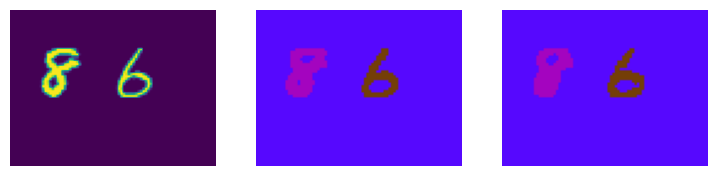

1/1 [==============================] - 0s 42ms/step
Digit 7 F1 score: 0.5105


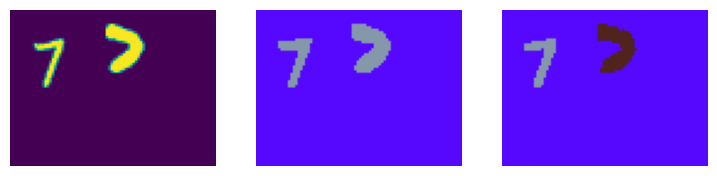

1/1 [==============================] - 0s 45ms/step
Digit 6 F1 score: 0.9488


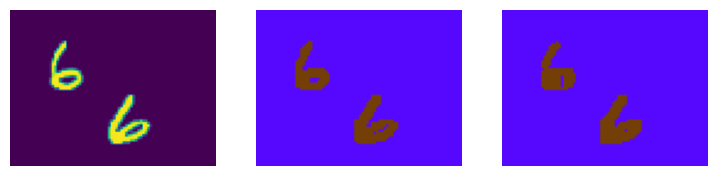

1/1 [==============================] - 0s 43ms/step
Digit 3 F1 score: 0.8104


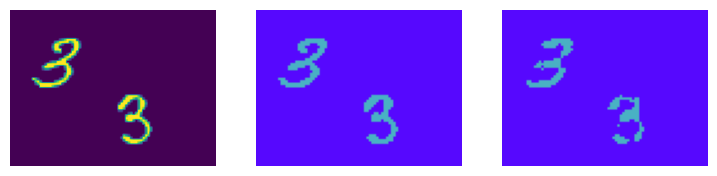

In [ ]:
unbatched_test = test_dataset.unbatch()

samples_amount = 10

for img, mask in unbatched_test.take(20):
    # Khởi tạo một biến dùng để chứa ảnh dự đoán
    pred_img = np.expand_dims(img, axis=0)
    # Dự đoán bằng cách sử dụng mô hình trên ảnh dự đoán
    pred = model.predict(pred_img)

    # Chuyển đổi mask và pred về dạng 2D bằng cách lấy chỉ số của giá trị lớn nhất
    mask = np.argmax(mask, axis=2)
    pred = np.argmax(pred, axis=3)

    # Tính toán F1 score cho từng class
    f1_per_class = get_f1_score_per_class(mask, np.squeeze(pred), CLASSES_AMOUNT-1)

    # Loại bỏ chiều thứ ba của mask và pred
    mask = np.squeeze(mask)
    pred = np.squeeze(pred)

    # In ra F1 score cho từng class khác 0
    for i in range(CLASSES_AMOUNT-1):
        if f1_per_class[i] != 0:
           print(f'Digit {i} F1 score: {f1_per_class[i]:.4f}')

    # Hiển thị hình ảnh gốc, mask và pred
    visualize_prediction(img, convert_mask_to_image(mask), convert_mask_to_image(pred))
    plt.pause(0.1)
